# Quantifying Chaos for a Dynamical System

Topics:
* Maximum Lyapunov Exponent
* Lyapunov Spectrum
* Detecting chaos using `gali`

**WARNING** - Compilation of functions in this tutorial takes *a lot of time*.

---

In the previous tutorial we saw that for example the Shinriki oscillator we saw something that "could be chaotic behavior" for a specific parameter value. How can we quantify that?

# Lyapunov exponents
* Lyapunov exponents measure the exponential separation of trajectories that are (initially) close. 
* A $D$ dimensional system has $D$ exponents. 
* These exponents are one of the most known and widely used quantities in nonlinear dynamics.
* In the introduction of our [official documentation](https://juliadynamics.github.io/DynamicalSystems.jl/latest/) we cite introductory textbooks to the field. These also have a lot of information on Lyapunov exponents!

**DynamicalSystems.jl** exports two functions for Lyapunov exponents, one for the maximum exponent and one for the spectrum.

In [1]:
using DynamicalSystems
# Since `lyapunov` is not a trivial function, it is best to read the documentation string first:

In [2]:
?lyapunov

search: lyapunov lyapunovs numericallyapunov



```
lyapunov(ds::DynamicalSystem, Τ; kwargs...) -> λ
```

Calculate the maximum Lyapunov exponent `λ` using a method due to Benettin [1], which simply evolves two neighboring trajectories (one called "given" and one called "test") while constantly rescaling the test one. `T`  denotes the total time of evolution (should be `Int` for discrete systems).

## Keyword Arguments

  * `Ttr = 0` : Extra "transient" time to evolve the trajectories before starting to measure the expontent. Should be `Int` for discrete systems.
  * `d0 = 1e-9` : Initial & rescaling distance between the two neighboring trajectories.
  * `upper_threshold = 1e-6` : Upper distance threshold for rescaling.
  * `lower_threshold = 1e-12` : Lower distance threshold for rescaling (in order to  be able to detect negative exponents).
  * `diff_eq_kwargs = Dict(:abstol=>d0, :reltol=>d0)` : (only for continuous) Keyword arguments passed into the solvers of the `DifferentialEquations` package (see [`trajectory`](@ref) for more info).
  * `dt = 1` : Time of evolution between each check of distance exceeding the thresholds. For continuous systems this is approximate.
  * `inittest = (u1, d0) -> u1 .+ d0/sqrt(D)` : A function that given `(u1, d0)` initializes the test state with distance `d0` from the given state `u1` (`D` is the dimension of the system). This function can be used when you want to avoid the test state appearing in a region of the phase-space where it would have e.g. different energy or escape to infinity.

## Description

Two neighboring trajectories with initial distance `d0` are evolved in time. At time $t_i$ their distance $d(t_i)$ either exceeds the `upper_threshold`, or is lower than `lower_threshold`, which initializes a rescaling of the test trajectory back to having distance `d0` from the given one, while the rescaling keeps the difference vector along the maximal expansion/contraction direction: $u_2 \to u_1+(u_2−u_1)/(d(t_i)/d_0)$.

The maximum Lyapunov exponent is the average of the time-local Lyapunov exponents

$$
\lambda = \frac{1}{t_{n}}\sum_{i=1}^{n}
\ln\left( a_i \right),\quad a_i = \frac{d(t_{i})}{d_0}.
$$

## Performance Notes

This function uses a `parallel_integrator`. For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

See the "advanced documentation" for info on the integrator object and use `@which ...` to go to the source code for the low-level call signature.

## References

[1] : G. Benettin *et al.*, Phys. Rev. A **14**, pp 2338 (1976)


---

Let's apply this to the example of the previous section, the Shinriki oscillator!

* Reminder: we found something that "could" be chaotic behavior for the parameter `R1 = 21.0`



In [3]:
shinriki_voltage(V) = 2.295e-5*(exp(3.0038*V) - exp(-3.0038*V))
function shinriki_eom(u, p, t)
    R1 = p[1]
    du1 = (1/0.01)*(
    u[1]*(1/6.9 - 1/R1) - shinriki_voltage(u[1] - u[2]) - (u[1] - u[2])/14.5
    )
    du2 = (1/0.1)*(
    shinriki_voltage(u[1] - u[2]) + (u[1] - u[2])/14.5 - u[3]
    )
    du3 = (1/0.32)*(-u[3]*0.1 + u[2])
    return SVector{3}(du1, du2, du3)
end

shi = ContinuousDynamicalSystem(shinriki_eom, [-2, 0, 0.2], [21.0])

3-dimensional continuous dynamical system
 state:     [-2.0, 0.0, 0.2]
 e.o.m.:    shinriki_eom
 in-place?  false
 jacobian:  ForwardDiff


In [4]:
lyapunov(shi, 1000.0, Ttr = 10.0)

0.02290509135307459

Positive Lyapunov exponent!?!? That is definitely chaotic behavior, right?

*Right?*

In [5]:
# Increase accuracy of computation, as well as 
# transient time, to see whether an orbit actually enters a limit cycle
lyapunov(shi, 2000.0, Ttr = 1000.0)

-0.0004697804235984747

**BAMBOOZLED**

In [6]:
# Let's find out whats going on!
# Produce a more detailed orbit diagram, around the "critical" 
# value of R = 21.0
pvalues = linspace(20.9,21.1,101)
i = 1
j = 2
tf = 1000.0
p_index = 1

# use extremely long transient time:
output = produce_orbitdiagram(shi, j, i, p_index, pvalues; tfinal = tf,
Ttr = 2000.0, direction = -1, printparams = false);

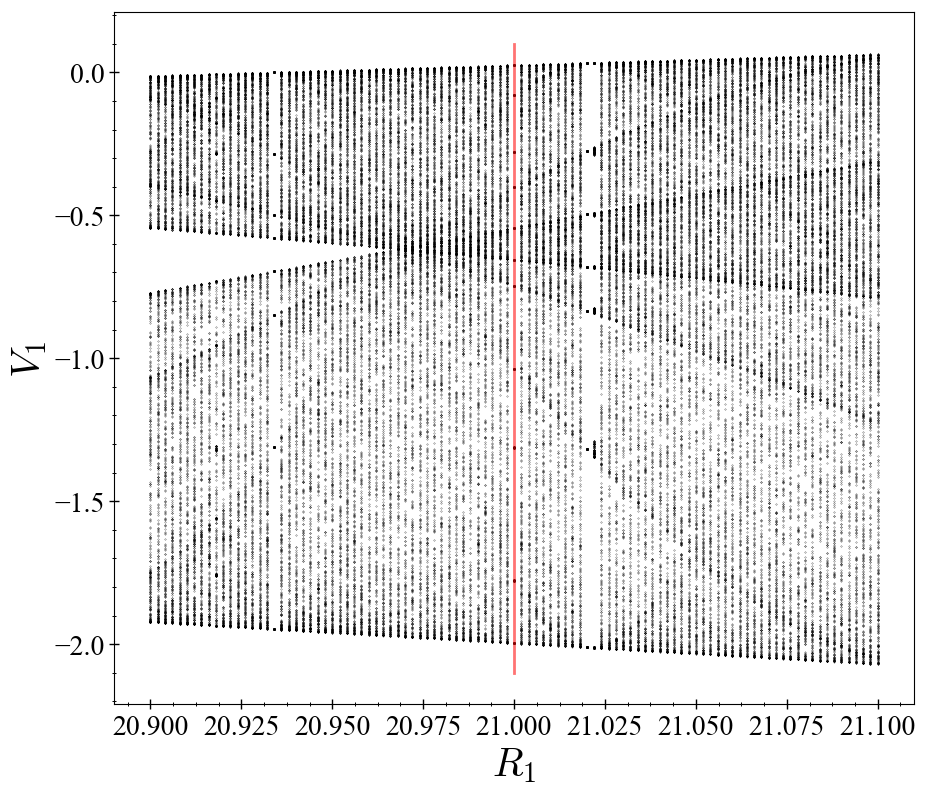

In [7]:
using PyPlot
figure()
for (j, p) in enumerate(pvalues)
    plot(p .* ones(output[j]), output[j], lw = 0,
    marker = "o", ms = 0.2, color = "black")
end
plot([21, 21], [-2.1, 0.1], color = "red", alpha = 0.55)
xlabel("\$R_1\$"); ylabel("\$V_1\$");

In [8]:
# Amount of different points
un = unique(round.(output[51], 4))
println("Total: $(length(output[51])), unique: $(length(un))")

Total: 758, unique: 20


---

# Lyapunov Spectrum 

Besides the maximum Laypunov exponent, the function `lyapunovs` (with `s` at the end) returns the entire Lyapunov spectrum (or as many exponents the user wants).

* All functions work with any instance of `DynamicalSystem`, regardless of whether it is continuous, discrete, in-place, out-of-place or whatever.

Once again, because the function `lyapunovs` is not trivial, we will view the documentation string first:

In [9]:
?lyapunovs

search: lyapunovs lyapunov numericallyapunov



```
lyapunovs(ds::DynamicalSystem, N, k::Int | Q0; kwargs...) -> λs
```

Calculate the spectrum of Lyapunov exponents [1] of `ds` by applying a QR-decomposition on the parallelepiped matrix `N` times. Return the spectrum sorted from maximum to minimum.

The third argument `k` is optional, and dictates how many lyapunov exponents to calculate (defaults to `dimension(ds)`). Instead of passing an integer `k` you can pass a pre-initialized matrix `Q0` whose columns are initial deviation vectors (then `k = size(Q0)[2]`).

## Keyword Arguments

  * `Ttr = 0` : Extra "transient" time to evolve the system before application of the algorithm. Should be `Int` for discrete systems. Both the system and the deviation vectors are evolved for this time.
  * `dt` : Time of individual evolutions between successive orthonormalization steps. Defaults to `1`. For continuous systems this is approximate.
  * `diff_eq_kwargs = Dict()` : (only for continuous) Keyword arguments passed into the solvers of the `DifferentialEquations` package (see [`trajectory`](@ref) for more info).

## Description

The method we employ is "H2" of [2], originally stated in [3]. The deviation vectors defining a `D`-dimensional parallepiped in tangent space are evolved using the tangent dynamics of the system. A QR-decomposition at each step yields the local growth rate for each dimension of the parallepiped. The growth rates are then averaged over `N` successive steps, yielding the lyapunov exponent spectrum (at each step the parallepiped is re-normalized).

## Performance Notes

This function uses a [`tangent_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

See the "advanced documentation" for info on the integrator object and use `@which ...` to go to the source code for the low-level call signature.

## References

[1] : A. M. Lyapunov, *The General Problem of the Stability of Motion*, Taylor & Francis (1992)

[2] : K. Geist *et al.*, Progr. Theor. Phys. **83**, pp 875 (1990)

[3] : G. Benettin *et al.*, Meccanica **15**, pp 9-20 & 21-30 (1980)


In [26]:
# Example, using discrete for a change
# towel map is a pre-defined 3-dimensional hyperchaotic map
# (hyperchaotic means many positive Lyapunov exponents)

# to access pre-defined systems, use the `Systems` module
towel = Systems.towel()
lyapunovs(towel, 2000; Ttr = 200)

3-element Array{Float64,1}:
  0.422617
  0.360382
 -3.27466 

In [27]:
# Compute only first 2 lyapunovs
lyapunovs(towel, 2000, 2; Ttr = 200)

2-element Array{Float64,1}:
 0.422632
 0.360369

In [28]:
# If you only want the first exponent (maximum)
# use the `lyapunov` function instead
lyapunov(towel, 2000; Ttr = 200)

0.4222043259222616

In [29]:
# How much time does it take?
using BenchmarkTools
@btime lyapunovs($towel, 2000; Ttr = 200);

  408.906 μs (184 allocations: 11.73 KiB)


Even the continuous systems are quite performant (note that compilation takes a **lot** of time):

In [31]:
# Initialize the lorenz system with random initial condition
ds = Systems.lorenz()

# Compute lyapunovs with specified Q0:
Q0 = eye(3)

lyapunovs(ds, 2000, Q0; Ttr = 10.0)

3-element Array{Float64,1}:
   0.894543  
   0.00114599
 -14.5624    

In [32]:
# Results "converge" already with 2000 iterations:
lyapunovs(ds, 3000, Q0; Ttr = 10.0)

3-element Array{Float64,1}:
   0.895384  
   0.00115214
 -14.5632    

In [33]:
@btime lyapunovs($ds, 2000.0, $Q0; Ttr = 10.0);

  125.242 ms (170 allocations: 25.11 KiB)


* The above integration is done with a 9th order solver and tolerances of `1e-9`. But you can get away with lower tolerances:

In [34]:
using OrdinaryDiffEq

# Keyword arguments passed into the integrators of DifferentialEquations.jl
dek = Dict(:solver => Tsit5(), :abstol => 1e-6, :reltol => 1e-6)

# Call lyapunovs with keyword `diff_eq_kwargs`
lyapunovs(ds, 2000.0, Q0; Ttr = 10.0, diff_eq_kwargs = dek)

3-element Array{Float64,1}:
   0.8945    
   0.00146117
 -14.5626    

In [35]:
@btime lyapunovs($ds, 2000.0, $Q0; Ttr = 10.0, diff_eq_kwargs = $dek);

  74.244 ms (180 allocations: 14.78 KiB)


# Detecting Chaos using `gali`
* In (for example) Hamiltonian systems, it is quite often the case that regular orbits (i.e. periodic) co-exist with chaotic orbits.
* Being able to detect and distinguish chaotic from regular behavior is crucial in the study of dynamical systems. 

Lyapunov exponents *can* be used for this task. However, the convergence of the Lyapunov exponent is often very slow and the computation costly. There are other alternatives that are both more efficient and more accurate in characterizing chaotic and regular motion.

One of the newest (and to the best of my knowledge fastest) methods is "GALI", generalized alignment index method.

* GALI uses the fact that deviation vectors (that live on tangent space) tend to align for chaotic motion, while they stay "not-aligned" for regular motion.

In [19]:
?gali

search: gali generalized_dim is_diagonal_noise eigvals eigvals! Diagonal global



```
gali(ds::DynamicalSystem, k::Int, tmax; kwargs...) -> GALI_k, t
```

Compute $\text{GALI}_k$ [1] for a given `k` up to time `tmax`. Return $\text{GALI}_k(t)$ and time vector $t$.

## Keyword Arguments

  * `threshold = 1e-12` : If `GALI_k` falls below the `threshold` iteration is terminated.
  * `dt = 1` : Time-step between variational vector normalizations. For continuous systems this is approximate.
  * `diff_eq_kwargs` : See [`trajectory`](@ref).
  * `u0` : Initial state for the system. Defaults to `state(ds)`.
  * `w0` : Initial orthonormal vectors (in matrix form). Defaults to `orthonormal(dimension(ds), k)`, i.e. `k` random orthonormal vectors.

## Description

The Generalized Alignment Index, $\text{GALI}_k$, is an efficient (and very fast) indicator of chaotic or regular behavior type in $D$-dimensional Hamiltonian systems ($D$ is number of variables). The *asymptotic* behavior of $\text{GALI}_k(t)$ depends critically of the type of orbit resulting from the initial condition `state(ds)`. If it is a chaotic orbit, then

$$
\text{GALI}_k(t) \sim
\exp\left[\sum_{j=1}^k (\lambda_1 - \lambda_j)t \right]
$$

with $\lambda_1$ being the maximum [`lyapunov`](@ref) exponent. If on the other hand the orbit is regular, corresponding to movement in $d$-dimensional torus with $1 \le d \le D/2$ then it holds

$$
\text{GALI}_k(t) \sim
    \begin{cases}
      \text{const.}, & \text{if} \;\; 2 \le k \le d  \; \; \text{and}
      \; \;d > 1 \\
      t^{-(k - d)}, & \text{if} \;\;  d < k \le D - d \\
      t^{-(2k - D)}, & \text{if} \;\;  D - d < k \le D
    \end{cases}
$$

Traditionally, if $\text{GALI}_k(t)$ does not become less than the `threshold` until `tmax` the given orbit is said to be chaotic, otherwise it is regular.

Our implementation is not based on the original paper, but rather in the method described in [2], which uses the product of the singular values of $A$, a matrix that has as *columns* the deviation vectors.

## Performance Notes

This function uses a [`tangent_integrator`](@ref). For loops over initial conditions and/or parameter values one should use the lower level methods that accept an integrator, and `reinit!` it to new initial conditions.

See the "advanced documentation" for info on the integrator object and use `@which ...` to go to the source code for the low-level call signature.

## References

[1] : Skokos, C. H. *et al.*, Physica D **231**, pp 30–54 (2007)

[2] : Skokos, C. H. *et al.*, *Chaos Detection and Predictability* - Chapter 5 (section 5.3.1 and ref. [85] therein), Lecture Notes in Physics **915**, Springer (2016)


---

The documentation string is super descriptive, because it is crucial to really know how the method works before using it.

Here I will only show a simple example of the standard map, which is a system with **mixed phase space**.

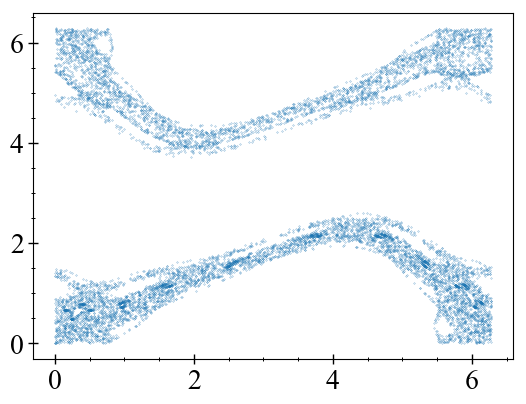

In [20]:
# Initialize with random chaotic initial condition:
sm = Systems.standardmap(;k = 1.0)
# Get trajectory:
tr = trajectory(sm, 10000)
# Plot it:
using PyPlot; figure(figsize=(6,4))
plot(tr[:, 1], tr[:, 2], ls = "None", marker = "o", ms = 0.2);

In [21]:
# Compute the gali_2 for this trajectory:
g, t = gali(sm, 2, 1000)
g

30-element Array{Float64,1}:
 1.0        
 0.620419   
 0.112297   
 0.0164787  
 0.00240461 
 0.000350934
 5.13054e-5 
 7.59101e-6 
 1.21928e-6 
 3.44477e-7 
 8.52216e-7 
 2.25616e-6 
 2.85265e-6 
 ⋮          
 3.68251e-8 
 6.82364e-9 
 1.01193e-9 
 1.79912e-10
 1.18626e-10
 2.53847e-10
 7.99257e-10
 4.21448e-10
 6.62314e-11
 9.70701e-12
 1.42131e-12
 2.1072e-13 

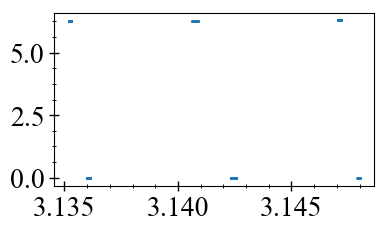

In [22]:
# Initialize with random regular initial condition:
sm = Systems.standardmap([π + 0.01*rand(), 0.01*rand()];k = 1.0)
# Get trajectory:
tr = trajectory(sm, 10000)
# Plot it:
using PyPlot; figure(figsize=(4,2))
plot(tr[:, 1], tr[:, 2], ls = "None", marker = "o", ms = 0.2);

In [23]:
# gali with regular initial condition:
g, t = gali(sm, 2, 1000)
g

1001-element Array{Float64,1}:
 1.0     
 0.822617
 0.666767
 1.0     
 0.822632
 0.666769
 1.0     
 0.822647
 0.666771
 1.0     
 0.822662
 0.666773
 1.0     
 ⋮       
 0.667457
 0.999999
 0.827572
 0.667459
 0.999999
 0.827587
 0.667462
 0.999999
 0.827602
 0.667464
 0.999999
 0.827617

As described by the documentation string of `gali`, `g` quickly decays to zero for a chaotic orbit, but is constant for a regular orbit (for the case of a 2D map).